## Analyzing borrowers’ risk of defaulting

Your project is to prepare a report for a bank’s loan division. You’ll need to find out if a customer’s marital status and number of children has an impact on whether they will default on a loan. The bank already has some data on customers’ credit worthiness.

Your report will be considered when building a **credit scoring** of a potential customer. A ** credit scoring ** is used to evaluate the ability of a potential borrower to repay their loan.

### Step 1. Open the data file and have a look at the general information. 

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/datasets/credit_scoring_eng.csv')
df.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,112080.014102,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,145885.952297,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,267628.550329,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,158616.077870,to have a wedding


# General Functions

In [2]:
def get_percent_of_na(df,num):
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index,s.values):
        print('Column {} has {:.{}%} percent of Nulls'.format(column, percent,num))
        
def get_negative_perc(df):
    df = df.copy()
    for col in df.columns:
        if np.issubdtype(df[col],np.number):
            s = (df[df[col] < 0][col].count() / df.shape[0])
            print('Column {} has {:.4%} percent of negative values'.format(col, s))
            
def get_dict(df,columns):
    if len(columns) > 2 or columns == []:
        return None
    
    df = df.copy()
    df_dict = df[columns].drop_duplicates().reset_index(drop=True)           
    return pd.Series(df_dict[columns[0]], index=df_dict[columns[1]]).to_dict()


def categorize_purpose(x):
    if 'educ' in x or 'univers' in x:
        return 'education'
    elif 'car' in x:
        return 'car'
    elif 'real' in x or 'estate' in x:
        return 'real estate'
    elif 'hous' in x or 'property' in x:
        return 'house'
    elif 'wed' in x:
        return 'wedding'
    else:
        'other'
        
        
def assign_total_income_category(quantiles,x):
    if x < quantiles[0]:
        return 'Low'
    elif x < quantiles[1]:
        return 'Medium'
    elif x < quantiles[2]:
        return 'Medium-High'
    else:
        return 'High'
    

def get_total_income_category(df,column,new_column):
    low = df[column].quantile(q=0.25)
    medium = df[column].quantile(q=0.5)
    medium_high = df[column].quantile(q=0.75)
    quantiles = [low, medium, medium_high]
    
    df[new_column] = df[column].apply(lambda x: assign_total_income_category(quantiles,x))
    return df[new_column]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [5]:
df.describe(include=['object'])

,education,family_status,gender,income_type,purpose
count,21525,21525,21525,21525,21525
unique,15,5,3,8,38
top,secondary education,married,F,employee,wedding ceremony
freq,13750,12380,14236,11119,797


In [6]:
print('Total NA of every column:')
get_percent_of_na(df,5)
print()
print('Total negative value for every column:')
get_negative_perc(df)

Total NA of every column:
Column children has 0.00000% percent of Nulls
Column days_employed has 10.09988% percent of Nulls
Column dob_years has 0.00000% percent of Nulls
Column education has 0.00000% percent of Nulls
Column education_id has 0.00000% percent of Nulls
Column family_status has 0.00000% percent of Nulls
Column family_status_id has 0.00000% percent of Nulls
Column gender has 0.00000% percent of Nulls
Column income_type has 0.00000% percent of Nulls
Column debt has 0.00000% percent of Nulls
Column total_income has 10.09988% percent of Nulls
Column purpose has 0.00000% percent of Nulls

Total negative value for every column:
Column children has 0.2184% percent of negative values
Column days_employed has 73.8955% percent of negative values
Column dob_years has 0.0000% percent of negative values
Column education_id has 0.0000% percent of negative values
Column family_status_id has 0.0000% percent of negative values
Column debt has 0.0000% percent of negative values
Column tota

### Conclusion

As we can see from looking into the general information about the data all columns have the right type but we have
some wired numbers such as:

<dl>
    <strong> <dt>1. Children Column </dt> </strong>
    <dd>
        <li> Min person has -1 children which is something that can not exist</li>
        <li> Max person has 20 children which is possible but according to <a href="https://ourworldindata.org/fertility-rate"> data </a> 
             <br> &nbsp &nbsp &nbsp  family has mean of 2.5 children per family will have to look into this column</li>
        <li> Some negative values, only 0.2% which is about 45 rows. Can consider to drop them</li>
    </dd>
</dl>

<dl>
    <strong> <dt>2. days_employed Column </dt> </strong>
    <dd>
        <li> Alot of negative values, almost 74% </li>
        <li> About 10% of nulls </li>
        <li> Max values is 401k which is 1110 years, impossible number</li>
        <li> Total of about 85% invalid values for the column</li>
    </dd>
</dl>

<dl>
    <strong> <dt>3. total_income Column </dt> </strong>
    <dd>
        <li> About 10% of null values</li>
    </dd>
</dl>


<dl>
    <strong> <dt>4. dob_years Column </dt> </strong>
    <dd>
        <li> Min value of 0, impossible age, probably has to be over 18 to get a loan</li>
    </dd>
</dl>


<dl>
    <strong> <dt>5. family_status Column </dt> </strong>
    <dd>
        <li> Probably family_status and family_status_id are telling the same</li>
    </dd>
</dl>

<dl>
    <strong> <dt>6. gender Column </dt> </strong>
    <dd>
        <li> 3 unique, will have to look into it</li>
</dl>

<dl>
    <strong> <dt>7. purpose Column </dt> </strong>
    <dd>
        <li> 38 different purposes, alot of mean the same such as: 'car', 'get a car' and so on, will need to dig into it</li>
    </dd>
</dl>

<dl>
    <strong> <dt>8. education Column </dt> </strong>
    <dd>
        <li> 15 different educations, need to inspect to check why only 5 education id.</li>
    </dd>
</dl>

### Step 2. Data preprocessing

In [7]:
dd = df.copy()

As I saw from looking into the data about the column days_employed:
* we have about 75% of negative values, 10% nulls therefor my decision is to  drop this column.

In [8]:
dd.drop(columns=['days_employed'],inplace=True)

As I saw from looking into the data about children columns:
* I have some impossible numbers, therefor I have to fix this. 
* I'll change -1 and to NaN then replace values with the median.
* As for 20 children, we have 76 rows, this might affect so I will keep them for now.

In [9]:
dd['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [10]:
dd['children'] = dd[dd['children']!= -1]['children']
dd['children'].fillna(dd['children'].median(),inplace=True)

In [11]:
dd['children'].value_counts()

0.0     14196
1.0      4818
2.0      2055
3.0       330
20.0       76
4.0        41
5.0         9
Name: children, dtype: int64

As I saw from looking into the data about dob_years columns:
* I have some impossible age, therefor I have to fix this. 

In [12]:
dd['dob_years'].value_counts().sort_values()

75      1
74      6
73      8
19     14
72     33
20     51
71     58
70     65
69     85
68     99
0     101
21    111
67    167
22    183
66    183
65    194
23    254
24    264
64    265
63    269
62    352
61    355
25    357
60    377
26    408
55    443
59    444
51    448
53    459
57    460
58    461
46    475
54    479
47    480
52    484
56    487
27    493
45    497
28    503
49    508
32    510
43    513
50    514
37    537
48    538
30    540
29    545
44    547
36    555
31    560
39    573
33    581
42    597
38    598
34    603
41    607
40    609
35    617
Name: dob_years, dtype: int64

In [13]:
dd['dob_years'] = dd[dd['dob_years'] !=0]['dob_years']
dd['dob_years'].fillna(dd['dob_years'].median(),inplace=True)

In [14]:
dd['dob_years'].value_counts()

35.0    617
43.0    614
40.0    609
41.0    607
34.0    603
38.0    598
42.0    597
33.0    581
39.0    573
31.0    560
36.0    555
44.0    547
29.0    545
30.0    540
48.0    538
37.0    537
50.0    514
32.0    510
49.0    508
28.0    503
45.0    497
27.0    493
56.0    487
52.0    484
47.0    480
54.0    479
46.0    475
58.0    461
57.0    460
53.0    459
51.0    448
59.0    444
55.0    443
26.0    408
60.0    377
25.0    357
61.0    355
62.0    352
63.0    269
64.0    265
24.0    264
23.0    254
65.0    194
66.0    183
22.0    183
67.0    167
21.0    111
68.0     99
69.0     85
70.0     65
71.0     58
20.0     51
72.0     33
19.0     14
73.0      8
74.0      6
75.0      1
Name: dob_years, dtype: int64

As I saw from looking into the data about gender column:
* I have some wired gender, therefor I have to fix this. 

In [15]:
dd['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [16]:
#Randomly choosing M
dd.loc[dd['gender'] == 'XNA','gender'] = 'M'

In [17]:
dd['gender'].value_counts()

F    14236
M     7289
Name: gender, dtype: int64

In [18]:
dd.head(1)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1.0,42.0,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house


Inspect education column to check wheter some process is needed

In [19]:
dd['education'].value_counts()

secondary education    13750
masters degree          4718
SECONDARY EDUCATION      772
Secondary Education      711
bachelor degree          668
MASTERS DEGREE           274
Masters Degree           268
primary education        250
Bachelor Degree           47
BACHELOR DEGREE           29
PRIMARY EDUCATION         17
Primary Education         15
academic degree            4
ACADEMIC DEGREE            1
Academic Degree            1
Name: education, dtype: int64

In [20]:
dd['education'] = dd['education'].str.lower()
dd['education'].value_counts()

secondary education    15233
masters degree          5260
bachelor degree          744
primary education        282
academic degree            6
Name: education, dtype: int64

We can see that we fixed all of the values types because of upper and lower cases.

### Processing missing values

In [21]:
get_percent_of_na(dd,5)

Column children has 0.00000% percent of Nulls
Column dob_years has 0.00000% percent of Nulls
Column education has 0.00000% percent of Nulls
Column education_id has 0.00000% percent of Nulls
Column family_status has 0.00000% percent of Nulls
Column family_status_id has 0.00000% percent of Nulls
Column gender has 0.00000% percent of Nulls
Column income_type has 0.00000% percent of Nulls
Column debt has 0.00000% percent of Nulls
Column total_income has 10.09988% percent of Nulls
Column purpose has 0.00000% percent of Nulls


As I saw from looking into the data about total_income column:
* I have some null values, therefor I have to fix this. 
* My thinking is to group by income_type, education and family_status because that these columns can affect on your salary.
  Then fill in missing values with median of the group.

In [23]:
group = dd.groupby(['family_status_id','children'])
group['total_income'].apply(lambda x: x.isna().sum()).sum()

2174

In [24]:
dd['total_income'] = group['total_income'].apply(lambda x:x.fillna(x.median()))

In [25]:
# Checking if we still have missing values:
group['total_income'].apply(lambda x: x.isna()).sum()

0

### Conclusion

In [26]:
dd.head(2)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1.0,42.0,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house
1,1.0,36.0,secondary education,1,married,0,F,employee,0,112080.014102,car purchase


After I have investigated the columns and fixed the values I can continue to my resreach. <br>
The only column that had Null values was total_income and I have dealt with it.

### Data type replacement

In [26]:
dd.dtypes

children            float64
dob_years           float64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

### Conclusion

Every column has its right type! <br>
I can continue.

### Processing duplicates

Firstly, I will check how many duplicates I have, after that drop the rows.

In [27]:
dd.duplicated().sum()

71

In [28]:
dd = dd.drop_duplicates().reset_index(drop=True)
dd.shape

(21454, 11)

### Conclusion

We did not have too much duplicates, which is good, we lost only 71 rows.

### Lemmatization

Lets take a look into the purpose column:

In [29]:
values = dd['purpose'].value_counts().index.tolist()
values

['wedding ceremony',
 'having a wedding',
 'to have a wedding',
 'real estate transactions',
 'buy commercial real estate',
 'housing transactions',
 'buying property for renting out',
 'transactions with the residential real estate',
 'purchase of the house',
 'housing',
 'purchase of the house for my family',
 'construction of own property',
 'property',
 'transactions with my real estate',
 'building a real estate',
 'buy real estate',
 'purchase of my own house',
 'building a property',
 'property renovation',
 'buy residential real estate',
 'buying my own car',
 'going to university',
 'car',
 'second-hand car purchase',
 'buying a second-hand car',
 'to own a car',
 'cars',
 'to buy a car',
 'car purchase',
 'supplementary education',
 'purchase of a car',
 'university education',
 'education',
 'to get asupplementary education',
 'getting an education',
 'profile education',
 'getting higher education',
 'to become educated']

Trying to find something with lemmas:

In [30]:
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemma = WordNetLemmatizer()
# importing to remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [31]:
[wordnet_lemma.lemmatize(w, pos = 'n') for w in values]

['wedding ceremony',
 'having a wedding',
 'to have a wedding',
 'real estate transactions',
 'buy commercial real estate',
 'housing transactions',
 'buying property for renting out',
 'transactions with the residential real estate',
 'purchase of the house',
 'housing',
 'purchase of the house for my family',
 'construction of own property',
 'property',
 'transactions with my real estate',
 'building a real estate',
 'buy real estate',
 'purchase of my own house',
 'building a property',
 'property renovation',
 'buy residential real estate',
 'buying my own car',
 'going to university',
 'car',
 'second-hand car purchase',
 'buying a second-hand car',
 'to own a car',
 'car',
 'to buy a car',
 'car purchase',
 'supplementary education',
 'purchase of a car',
 'university education',
 'education',
 'to get asupplementary education',
 'getting an education',
 'profile education',
 'getting higher education',
 'to become educated']

There is no change, lets try another thing.

In [32]:
words = [val.split() for val in values]
remove_stop = []
i = 0
for val in words:
    new_val = val
    for stop in stop_words:
        if stop in val:
            new_val.remove(stop)
    remove_stop.append(new_val)
    
remove_stop

[['wedding', 'ceremony'],
 ['wedding'],
 ['wedding'],
 ['real', 'estate', 'transactions'],
 ['buy', 'commercial', 'real', 'estate'],
 ['housing', 'transactions'],
 ['buying', 'property', 'renting'],
 ['transactions', 'residential', 'real', 'estate'],
 ['purchase', 'house'],
 ['housing'],
 ['purchase', 'house', 'family'],
 ['construction', 'property'],
 ['property'],
 ['transactions', 'real', 'estate'],
 ['building', 'real', 'estate'],
 ['buy', 'real', 'estate'],
 ['purchase', 'house'],
 ['building', 'property'],
 ['property', 'renovation'],
 ['buy', 'residential', 'real', 'estate'],
 ['buying', 'car'],
 ['going', 'university'],
 ['car'],
 ['second-hand', 'car', 'purchase'],
 ['buying', 'second-hand', 'car'],
 ['car'],
 ['cars'],
 ['buy', 'car'],
 ['car', 'purchase'],
 ['supplementary', 'education'],
 ['purchase', 'car'],
 ['university', 'education'],
 ['education'],
 ['get', 'asupplementary', 'education'],
 ['getting', 'education'],
 ['profile', 'education'],
 ['getting', 'higher', 'ed

Adding stemming to understand better:

In [33]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()
d = [porter.stem(item) for word in words for item in word]

dic = {}
for item in d:
    dic[item] = dic.get(item,0) + 1
    
sorted(dic.items(), key=lambda item: -item[1])

[('car', 9),
 ('educ', 8),
 ('real', 7),
 ('estat', 7),
 ('buy', 7),
 ('purchas', 6),
 ('hous', 5),
 ('properti', 5),
 ('transact', 4),
 ('wed', 3),
 ('get', 3),
 ('residenti', 2),
 ('build', 2),
 ('univers', 2),
 ('second-hand', 2),
 ('ceremoni', 1),
 ('commerci', 1),
 ('rent', 1),
 ('famili', 1),
 ('construct', 1),
 ('renov', 1),
 ('go', 1),
 ('supplementari', 1),
 ('asupplementari', 1),
 ('profil', 1),
 ('higher', 1),
 ('becom', 1)]

### Conclusion

After filtering the unique values I can tell that we have some unique groups: car, educ, buy real estate, hous property, wed

### Categorizing Data

In [34]:
dd.head(1)

,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1.0,42.0,masters degree,0,married,0,F,employee,0,253875.639453,purchase of the house


In [35]:
#create a dict from two columns that means the same so can drop the other one.
family_status_dict = get_dict(dd,['family_status','family_status_id'])
dd.drop(columns=['family_status_id'],inplace=True)

In [36]:
#create a dict from two columns that means the same so can drop the other one.
edu_status_dict = get_dict(dd,['education','education_id'])
dd.drop(columns=['education_id'],inplace=True)

In [37]:
#categorize purpose column
dd['purpose_categorize'] = dd['purpose'].apply(categorize_purpose)

In [38]:
# categorize total_income category to handle continuous variable
# I decide to make 4 categoies: low, medium,medium-high, high
dd['total_income_category'] = get_total_income_category(dd,'total_income','total_income_category')

### Conclusion

In [39]:
dd.head(2)

,children,dob_years,education,family_status,gender,income_type,debt,total_income,purpose,purpose_categorize,total_income_category
0,1.0,42.0,masters degree,married,F,employee,0,253875.639453,purchase of the house,house,High
1,1.0,36.0,secondary education,married,F,employee,0,112080.014102,car purchase,car,Medium


I have dropped two columns and created a dictionary so I do not lose information. Both dropped column had the same meaning as other column so I did not need to keep it. <br><br> About purpose column I have decided to categorized it into 6 groups: house, real estate, car, education, wedding and other.<br> After counting the values I can tell that I might have caught all of the groups (no 'other' group).
<br><br>
I also decided to create a category column from the total_income for later use.

### Step 3. Answer these questions

- Is there a relation between having kids and repaying a loan on time?

In [42]:
dd[(dd['children'] >0) & (dd['debt'] == 0)].shape[0] / dd[dd['children'] >0].shape[0]

0.9074630945872061

### Conclusion

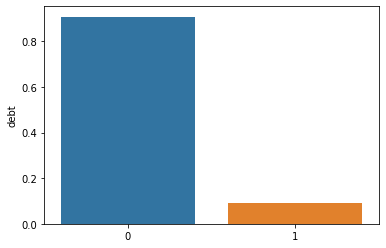

In [41]:
sns.barplot(x=[0,1], y=dd[dd['children'] >0]['debt'].value_counts(normalize=True))

90% of the customers that have children pay theirs debt!

- Is there a relation between marital status and repaying a loan on time?

In [43]:
for status in family_status_dict.values():
    perc = dd[(dd['family_status'] == status) & (dd['debt'] == 0)].shape[0] / dd[(dd['family_status'] == status)].shape[0]
    print('{:.2%} of the family status {} have paid theirs loans'.format(perc,status))

92.45% of the family status married have paid theirs loans
90.65% of the family status civil partnership have paid theirs loans
93.43% of the family status widow / widower have paid theirs loans
92.89% of the family status divorced have paid theirs loans
90.25% of the family status unmarried have paid theirs loans


### Conclusion

I can tell that at least of 90% for every family status pay back theirs loan.
I can conclude that there is no relation between family status and repaying back the loan.

- Is there a relation between income level and repaying a loan on time?

In [44]:
for status in set(dd['total_income_category']):
    perc = dd[(dd['total_income_category'] == status) & (dd['debt'] == 0)].shape[0] / dd[(dd['total_income_category'] == status)].shape[0]
    print('{:.2%} of income level {} have paid theirs loans'.format(perc,status))

92.86% of income level High have paid theirs loans
91.22% of income level Medium have paid theirs loans
91.40% of income level Medium-High have paid theirs loans
92.04% of income level Low have paid theirs loans


### Conclusion

As I can see, it does not matter what is the income level of a customer, 90% of the times they pay it back.

- How do different loan purposes affect on-time repayment of the loan?

In [45]:
for status in set(dd['purpose_categorize']):
    perc = dd[(dd['purpose_categorize'] == status) & (dd['debt'] == 0)].shape[0] / dd[(dd['purpose_categorize'] == status)].shape[0]
    print('{:.2%} of purpose category {} have paid theirs loans'.format(perc,status))

90.64% of purpose category car have paid theirs loans
92.97% of purpose category house have paid theirs loans
92.47% of purpose category real estate have paid theirs loans
90.78% of purpose category education have paid theirs loans
92.00% of purpose category wedding have paid theirs loans


### Conclusion

As I can see, it does not matter what is the income level of a customer, 90% of the times they pay it back.

### Step 4. General conclusion

After my investigation of the data I conclude that neither the customers martial status nor his number of children have an impact of his will to repay his debt. <br>
None of the variable that were inspected had a blurry conclusion, it was determined that every one paid theirs debt (more than 90% for each inspected case. <br> <br>

To conclude, my final decision is that none of martial status, number of children, total_income, education can tell us if the customer will not repay his debt.


### Project Readiness Checklist

Put 'x' in the completed points. Then press Shift + Enter.

- [x]  file open;
- [x]  file examined;
- [x]  missing values defined;
- [x]  missing values are filled;
- [x]  an explanation of which missing value types were detected;
- [x]  explanation for the possible causes of missing values;
- [x]  an explanation of how the blanks are filled;
- [x]  replaced the real data type with an integer;
- [x]  an explanation of which method is used to change the data type and why;
- [x]  duplicates deleted;
- [x]  an explanation of which method is used to find and remove duplicates;
- [x]  description of the possible reasons for the appearance of duplicates in the data;
- [x]  highlighted lemmas in the values of the loan purpose column;
- [x]  the lemmatization process is described;
- [x]  data is categorized;
- [x]  an explanation of the principle of data categorization;
- [x]  an answer to the question "Is there a relation between having kids and repaying a loan on time?";
- [x]  an answer to the question " Is there a relation between marital status and repaying a loan on time?";
- [x]   an answer to the question " Is there a relation between income level and repaying a loan on time?";
- [x]  an answer to the question " How do different loan purposes affect on-time repayment of the loan?"
- [x]  conclusions are present on each stage;
- [x]  a general conclusion is made.